# Lab 3 - Nim  
## Task 3.2 - An agent using evolved rules

Here for semplicity, I will consider the parameter k always equal to None

In [1]:
import logging
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

from nim import Nimply, Nim
from play_nim import *
# inside play_nim: 
#   Functions:  nim_sum, dumb_action, dumb_random_action,
#               random_action, layered_action, demigod_action,
#               expert_action, evaluate
#   Dictionary: opponents

In [2]:
logging.basicConfig(format="%(message)s", level=logging.INFO)

## Implementation

### Individual

In [3]:
class EvolvedPlayer():
  """
    This played uses GA to evolve some rules
    that lets him play the game (hopefully better every time).  

    The genome will be a list of rules that will be applyed 
    in order. The information lies inside the order of the rules, that 
    can change with genetic operations (XOVER and MUT).
  """

  def __init__(self, nim: Nim, genome=None):
    self._k = nim._k
    self.score = -1
    self.__collect_info(nim) # Cooked info
    self.rules = self.__rules()
    if genome:
      assert len(genome) == len(self.rules)
      self.genome = genome
    else: 
      self.genome = list(self.rules.keys())
      random.shuffle(self.genome) 


  def __collect_info(self, nim: Nim):
    """
      Collects some info:
      - number of not zero rows
      - sorted rows by number of objects
      - average number of objects per row
    """
    self.n_rows_left = len([r for r in nim._rows if r > 0])
    self.sorted_rows = sorted([(r, n) for r, n in enumerate(nim._rows) if n > 0], key=lambda r: -r[1])
    self.avg_obj_per_row = sum(nim._rows) / len(nim._rows)    


  def __rules(self):
    """
    Returns a set of fixed rules as a dicitonary.  
    The dictionary will be as follows:
      - key: id as incremental number
      - value: tuple with (condition, action), where 
        - condition = boolean condition that has to be true in order to perform the action
        - action = Nimply action 
    """

    assert self.n_rows_left
    assert self.sorted_rows
    assert self.avg_obj_per_row
    
    ### Conditions and Actions ###

    # 1 row left --> take the entire row
    def c1(self): 
      return self.n_rows_left == 1
    def a1(self):
      return Nimply(self.sorted_rows[0][0], self.sorted_rows[0][1])

    # 2 rows left --> leave the same number of objs
    def c2(self):
      return self.n_rows_left == 2 and self.sorted_rows[0][1] != self.sorted_rows[1][1]
    def a2(self):
      num_obj = self.sorted_rows[0][1] - self.sorted_rows[1][1]
      return Nimply(self.sorted_rows[0][0], num_obj)

    # 2 rows left and len longest row > avg --> leave one obj in the higher row
    def c3(self):
      return self.n_rows_left == 2 and self.sorted_rows[0][1] > self.avg_obj_per_row and self.sorted_rows[0][1]>1
    def a3(self):
      return Nimply(self.sorted_rows[0][0], self.sorted_rows[0][1] - 1)

    # 3 rows left --> take the entire max row
    def c4(self):
      return self.n_rows_left == 3
    def a4(self):
      return Nimply(self.sorted_rows[0][0], self.sorted_rows[0][1])

    # 3 rows left --> take leave the longest row with one obj
    def c5(self):
      return self.n_rows_left == 3 and self.sorted_rows[0][1] > 1
    def a5(self):
      return Nimply(self.sorted_rows[0][0], self.sorted_rows[0][1] - 1)
    
    # avg < max+1 --> take the longest row
    def c6(self):
      return self.avg_obj_per_row < self.sorted_rows[0][1] + 1
    def a6(self):
      return Nimply(self.sorted_rows[0][0], self.sorted_rows[0][1])

    # default -> take one obj from the longest row
    def c7(self):
      return True
    def a7(self):
      return Nimply(self.sorted_rows[0][0], 1)


    ### Rule dictionary ###
    dict_rules = {
      1: (c1, a1),
      2: (c2, a2),
      3: (c3, a3),
      4: (c4, a4),
      5: (c5, a5),
      6: (c6, a6),
      7: (c7, a7)
    }
  
    return dict_rules


  def ply(self, nim: Nim):
    """
      Check the rules in order. The first rule that matches will be applyed
    """
    # Update the informations
    self.__collect_info(nim)

    # Apply a rule
    for key in self.genome:
      cond, act = self.rules[key]
      if cond(self):
        logging.debug(f'--> RULE number {key} applyed')
        return act(self)


  def set_score(self, score):
    self.score = score


  def clear_score(self):
    self.score = -1


  def cross_over(self, partner, nim):
    """ 
      Cycle crossover: choose two loci l1 and l2 (not included) and copy the segment
      between them from p1 to p2, then copy the remaining unused values
    """
    locus1 = random.randint(0, len(self.genome)-1)
    while (locus2 := random.randint(0, len(self.genome)-1)) == locus1:
      pass
    if locus1 > locus2:
      tmp = locus1
      locus1 = locus2
      locus2 = tmp

    # Segment extraction
    segment_partner = partner.genome[locus1:locus2] # slice
    alleles_left = [a for a in self.genome if a not in segment_partner]
    #random.shuffle(alleles_left)

    # Create the offspring genome
    piece1 = alleles_left[:locus1]
    piece2 = alleles_left[locus1:]
    offspring_genome = piece1 + segment_partner + piece2
    
    return EvolvedPlayer(nim, offspring_genome)


  def mutation(self):
    """
      Swap mutation: alleles in two random loci are swapped
    """
    locus1 = random.randint(0, len(self.genome)-1)
    while (locus2 := random.randint(0, len(self.genome)-1)) == locus1:
      pass
    
    # Swap mutation
    tmp = self.genome[locus1]
    self.genome[locus1] = self.genome[locus2]
    self.genome[locus2] = tmp



### Evolution

In [4]:
def initial_population(population_size: int, nim: Nim):
  population = []
  for i in range(population_size):
    population.append(EvolvedPlayer(nim))
  
  return population

In [5]:
def tournament(population, tournament_size=2):
  return max(random.choices(population, k=tournament_size), key=lambda i: -i.score)

In [6]:
def island(nim, population, generations=1, *, opponent, selective_pressure, mut_prob, matches_1v1, evolve=True, display_matches=False, display_survivals=False):

  for gen in range(generations):
    # Play
    for player in population:
      won_p = evaluate(nim, 
                        n_matches=matches_1v1, 
                        my_action=player.ply,
                        opponent_action=opponent)
      player.set_score(won_p)
      if display_matches:
        logging.info(f'Player {player.genome} has a win rate={player.score}')

    # Evolution
    
    best_population = [i for i in population if i.score > selective_pressure]
    offspring_size = len(population) - len(best_population)
    
    if display_survivals:
      logging.info(f'- Survivals = {len(best_population)}')

    if evolve:
      for i in range(offspring_size):
        p1 = tournament(best_population)
        p2 = tournament(best_population)
        o = p1.cross_over(p2, nim)       # XOVER
        if random.random() < mut_prob:   # MUT
          p1.mutation()
        best_population.append(o)
      population = best_population    

    return population

In [7]:
def genetic_algorithm(nim: Nim, population, *, generations=100, matches_island=5, matches_1v1=20, display_survivals=False):
  """
    The algorithm is based on islands.  
    Each island have a different opponent to match with increasing difficulty.  
    It goes from the dumb strategy to the god strategy (expert agent).  
    There will be matches_island matches on each island and the genetic operations 
    will be applyed after the end of the competition. The best individuals (the ones 
    that won more matches) will pass to the next generation, while the others will perish.
    The offsprings will replace the missing individuals.
  """
  # I imported the opponents and the evaluation function from play_nim.py 
  log_best1 = []
  log_best2 = []
  log_best3 = []
  log_best4 = []
  log_best5 = []
  selective_pressure = 0.5
  mut_prob = 0.01

  for i in tqdm(range(generations)):

    ####  ISLAND 1: population vs dumb agent  ####
    if display_survivals:
      logging.info(f'ISLAND 1: population vs dumb agent')

    survivals1 = island(nim, population, matches_island,
                          opponent=opponents[1],
                          selective_pressure=0.7,
                          mut_prob=mut_prob,
                          matches_1v1=matches_1v1,
                          display_survivals=display_survivals)
    log_best1.append((i, max([p for p in survivals1 if p.score>0], key=lambda i: -i.score)))


    ####  ISLAND 2: population vs dumb random agent  ####
    if display_survivals:
      logging.info(f'ISLAND 2: population vs dumb random agent')

    survivals2 = island(nim, survivals1,  matches_island,
                          opponent=opponents[2],
                          selective_pressure=selective_pressure,
                          mut_prob=mut_prob,
                          matches_1v1=matches_1v1,
                          display_survivals=display_survivals)  
    log_best2.append((i, max([p for p in survivals2 if p.score>0], key=lambda i: -i.score)))

    ####  ISLAND 3: population vs dumb random agent  ####
    if display_survivals:
      logging.info(f'ISLAND 3: population vs random agent')

    survivals3 = island(nim, survivals2, matches_island,
                          opponent=opponents[3],
                          selective_pressure=selective_pressure,
                          mut_prob=mut_prob,
                          matches_1v1=matches_1v1,
                          display_survivals=display_survivals)
    log_best3.append((i, max([p for p in survivals3 if p.score>0], key=lambda i: -i.score)))  
    
    ####  ISLAND 4: population vs layered agent  ####
    if display_survivals:
      logging.info(f'ISLAND 4: population vs layered agent')

    survivals4 = island(nim, survivals3, matches_island,
                          opponent=opponents[4],
                          selective_pressure=selective_pressure,
                          mut_prob=mut_prob,
                          matches_1v1=matches_1v1,
                          display_survivals=display_survivals)  
    log_best4.append((i, max([p for p in survivals4 if p.score>0], key=lambda i: -i.score)))  

    ####  ISLAND 5: population vs demigod agent  ####
    if display_survivals:
      logging.info(f'ISLAND 5: population vs demigod agent')

    survivals5 = island(nim, survivals4, matches_island,
                          opponent=opponents[5],
                          selective_pressure=selective_pressure,
                          mut_prob=mut_prob,
                          matches_1v1=matches_1v1,
                          display_survivals=display_survivals) 
    log_best5.append((i, max([p for p in survivals5 if p.score>0], key=lambda i: -i.score)))

    population = survivals5
   
  ####  ISLAND 6: population vs god agent  ####
  logging.info(f'ISLAND 6: population vs god agent')
  survivals6 = island(nim, survivals5,
                        opponent=opponents[6],
                        selective_pressure=0,
                        mut_prob=0,
                        matches_1v1=matches_1v1,
                        display_matches=False,
                        display_survivals=True,
                        evolve=False) 
  defeated_god = [p for p in survivals6 if p.score > 0]
  if defeated_god:
    for champion in defeated_god:
      logging.info(f'CHAMPION {champion.genome} defeated GOD (score={champion.score})')
  else:
    logging.info(f'God won\n')


  log_best_generation = (log_best1, log_best2, log_best3, log_best4, log_best5)
  return population, log_best_generation
  

## Play

In [17]:
POPULATION_SIZE = 500

nim = Nim(7)
population = initial_population(POPULATION_SIZE, nim)

survivals, log_best = genetic_algorithm(nim, population,
                                          matches_island=50,
                                          matches_1v1=10,
                                          display_survivals=False)

parent_survivals = [p for p in survivals if p.score > 0]
logging.info('Survivals:')
for i in range(len(parent_survivals)):
  logging.info(f'- Player {parent_survivals[i].genome} with score {parent_survivals[i].score}')
  

100%|██████████| 100/100 [16:26<00:00,  9.86s/it]
ISLAND 6: population vs god agent
- Survivals = 0
God won

Survivals:


In [18]:
log1, log2, log3, log4, log5 = log_best
bests = []
bests.append(max(log1, key=lambda x: x[1].score))
bests.append(max(log2, key=lambda x: x[1].score))
bests.append(max(log3, key=lambda x: x[1].score))
bests.append(max(log4, key=lambda x: x[1].score))
bests.append(max(log5, key=lambda x: x[1].score))

logging.info('Best players:')
for i in range(5):
  logging.info(f'Island {i} - player {bests[i][1].genome} with score {bests[i][1].score} at generation {bests[i][0]}')

Best players:
Island 0 - player [2, 5, 1, 7, 4, 6, 3] with score 0.5 at generation 1
Island 1 - player [2, 7, 1, 4, 5, 6, 3] with score 0.5 at generation 0
Island 2 - player [1, 7, 3, 2, 6, 4, 5] with score 0.5 at generation 3
Island 3 - player [1, 3, 5, 4, 2, 7, 6] with score 0.5 at generation 0
Island 4 - player [3, 2, 4, 5, 1, 7, 6] with score 0.5 at generation 10


### Plots

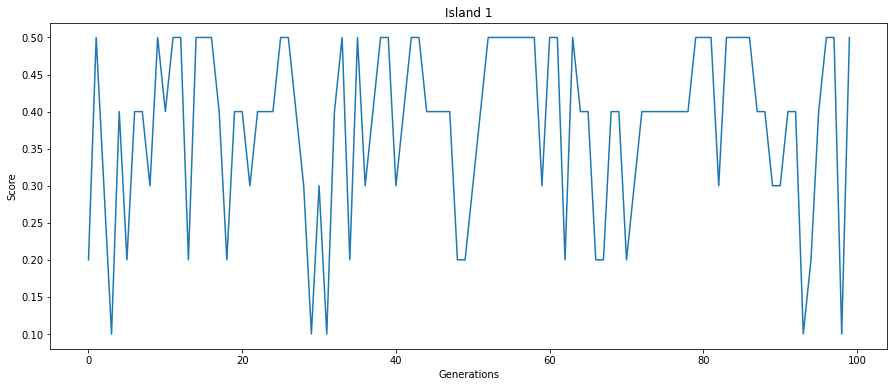

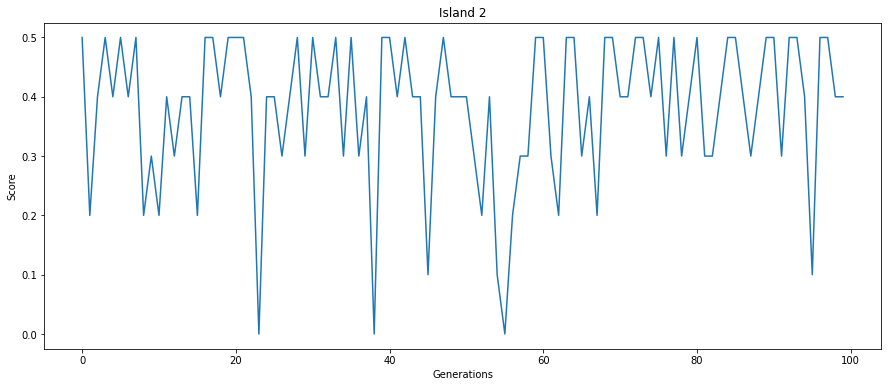

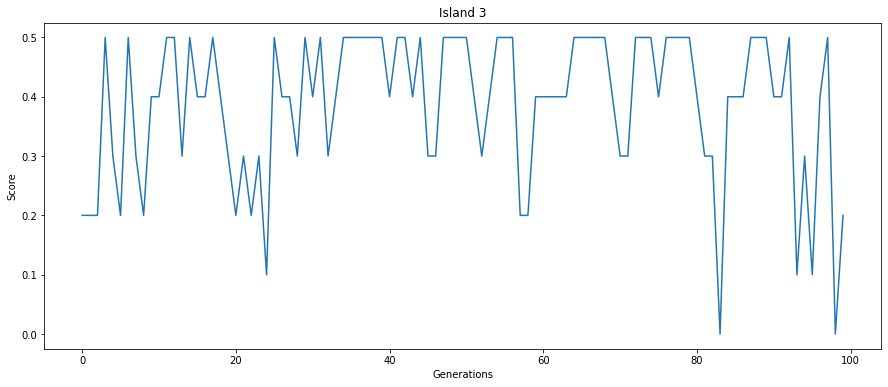

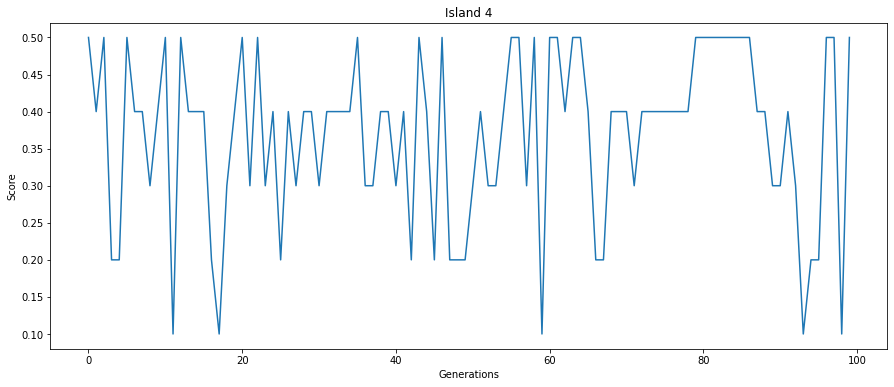

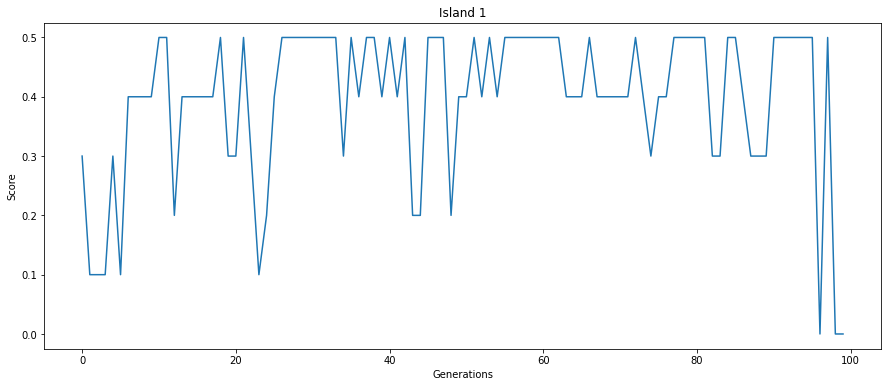

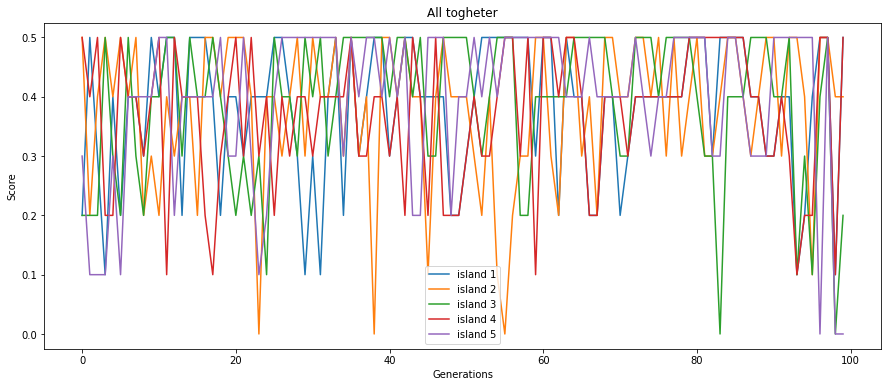

In [19]:
log1, log2, log3, log4, log5 = log_best

# Island 1
plt.figure(figsize=(15, 6))
plt.title('Island 1')
plt.ylabel('Score')
plt.xlabel('Generations')
plt.plot([x for x, _ in log1], [y.score for _, y in log1], label='island 1')


# Island 2
plt.figure(figsize=(15, 6))
plt.title('Island 2')
plt.ylabel('Score')
plt.xlabel('Generations')
plt.plot([x for x, _ in log2], [y.score for _, y in log2], label='island 2')


# Island 3
plt.figure(figsize=(15, 6))
plt.title('Island 3')
plt.ylabel('Score')
plt.xlabel('Generations')
plt.plot([x for x, _ in log3], [y.score for _, y in log3], label='island 3')


# Island 4
plt.figure(figsize=(15, 6))
plt.title('Island 4')
plt.ylabel('Score')
plt.xlabel('Generations')
plt.plot([x for x, _ in log4], [y.score for _, y in log4], label='island 4')

# Island 5
plt.figure(figsize=(15, 6))
plt.title('Island 1')
plt.ylabel('Score')
plt.xlabel('Generations')
plt.plot([x for x, _ in log5], [y.score for _, y in log5], label='island 5')

# All togheter
plt.figure(figsize=(15, 6))
plt.title('All togheter')
plt.ylabel('Score')
plt.xlabel('Generations')
plt.plot([x for x, _ in log1], [y.score for _, y in log1], label='island 1')
plt.plot([x for x, _ in log2], [y.score for _, y in log2], label='island 2')
plt.plot([x for x, _ in log3], [y.score for _, y in log3], label='island 3')
plt.plot([x for x, _ in log4], [y.score for _, y in log4], label='island 4')
plt.plot([x for x, _ in log5], [y.score for _, y in log5], label='island 5')
plt.legend()

